## Calculation of a confident interval for LSTM model of time-series

References:

1. The book "Hands-On Machine Learning with Scikit-Learn and TensorFlow"
    - By: Manpreet Singh Ghotra; Rajdeep Dua
    - Publisher: Packt Publishing
    - Pub. Date: November 10, 2017
2. [Applying Deep Learning to Time Series Forecasting with TensorFlow](https://mapr.com/blog/deep-learning-tensorflow/)
3. [hunkim/DeepLearningZeroToAll](https://github.com/hunkim/DeepLearningZeroToAll/blob/master/lab-12-5-rnn_stock_prediction.py)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import importlib
import pathlib
import shutil
%matplotlib inline

In [4]:
import tensorflow as tf
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as tfmetrics
import tensorflow.contrib.rnn as tfrnn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
tf.__version__

'1.3.0'

In [5]:
# create test data x_test, y_test using sin generator
# for example, x_test is (1, 20, 1)

In [6]:
# Add generators from ../src
p_src = [pathlib.Path("../src"), pathlib.Path('../historical_data')]
path_add = [p.resolve().expanduser().absolute() for p in p_src]
import os, sys
for elem in path_add:
    sys.path.append(str(elem))
import data_generator  # initial import

In [7]:
# Parameters
import os
try:
    os.path.mkdir('models')
except:
    pass
# MODEL_PATH = os.path.join('models', "lstm-5-model")
STATE_FOLD = "model_state"
MODEL_NAME = "lstm-7"

DATA_FILE = '../historical_data/coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv'
INPUTS = 1  # how many inputs
OUTPUTS = 1  # how many outputs

In [8]:
class TimeRec:
    def __init__(self):
        self._time0 = time.monotonic()
        self._last = self._time0
        
    def step(self):
        delta = time.monotonic() - self._last
        self._last = time.monotonic()
        return delta
    
    def total(self):
        return time.monotonic() - self._time0
    
    def __str__(self):
        return 'Total: {:.3f} sec'.format(self.total())

In [9]:
tr = TimeRec()
importlib.reload(data_generator)
vals, dates = data_generator.csv_reader(DATA_FILE, 'Weighted_Price', 'Timestamp')
vals_len = vals.shape[0]
str(tr), vals_len

('Total: 2.740 sec', 1574274)

### Two sets of parameters.

The CHECK_SETS is used for tuning the software, an algorithm, a graph representaion.<br/>
The GPU_SETS is used to train the model on a computer with GPU. For this example it is a computer on Google Cloud

In [10]:
class Settings:
      def __init__(self, *, model_name, state_fold, data_generator, neurons, loss, x_steps, y_steps, 
                   learning_rate, train_sz, validate_sz, batch_sz, epochs):
        # settings
        self.state_fold = state_fold
        self.model_name = model_name
        self.data_generator = data_generator
        self.neurons = neurons
        self.loss = loss
        self.x_steps = x_steps
        self.y_steps = y_steps
        self.learning_rate = learning_rate
        self.train_sz = train_sz
        self.validate_sz = validate_sz
        self.batch_sz = batch_sz
        self.epochs = epochs
        self.validate_bg = -1
        self.train_bg = -1


CHECK_SETS = Settings(model_name=MODEL_NAME, state_fold=STATE_FOLD, data_generator=data_generator, 
                      neurons=[32], loss=0.1, x_steps=10, y_steps=10, 
                      learning_rate=0.001, train_sz=3000, validate_sz=100, batch_sz=5, epochs=3)

GPU_SETS = Settings(model_name=MODEL_NAME, state_fold=STATE_FOLD, data_generator=data_generator, 
                    neurons=[32, 32], loss=0.1, x_steps=20, y_steps=20, 
                    learning_rate=0.003, train_sz=10000, validate_sz=100, batch_sz=150, epochs=200)
    
SETS = GPU_SETS    

### Show the whole training data set and selected range

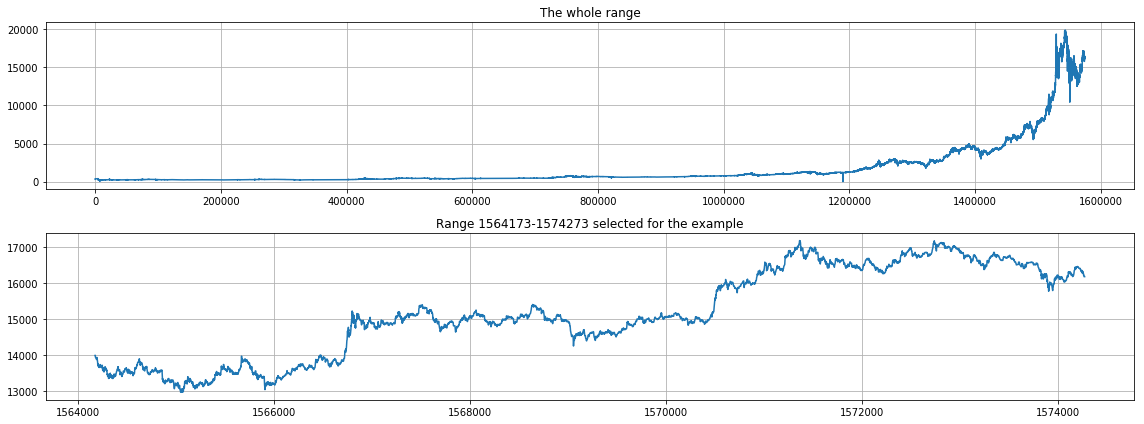

In [48]:
plt.figure(figsize=(16, 6))
plt.subplot(2,1,1)
plt.plot(vals)
plt.grid(True)
plt.title("The whole range")
plt.subplot(2,1,2)
xmax = vals_len - 1
xmin = xmax - SETS.train_sz - SETS.validate_sz
plt.plot(list(np.linspace(xmin, xmax-1, xmax-xmin)), vals[xmin:xmax])
plt.title("Range {}-{} selected for the example".format(xmin, xmax))
plt.grid(True)
plt.tight_layout()

In [13]:
# Selected range is from TRAIN_BG until the end
SETS.validate_bg = vals_len - SETS.validate_sz
SETS.train_bg = SETS.validate_sz - SETS.train_sz
validation_vals = vals[SETS.validate_bg:]
train_vals = vals[SETS.train_bg:SETS.validate_bg]
train_dates = np.linspace(0, SETS.train_sz-1, SETS.train_sz)
validation_dates = np.linspace(SETS.train_sz, SETS.train_sz+SETS.validate_sz-1, SETS.validate_sz)

In [14]:
# Check that X step is 1 and dates are continuous
train_dates[-3:], validation_dates[:3]

(array([ 9997.,  9998.,  9999.]), array([ 10000.,  10001.,  10002.]))

In [15]:
# Create a data source. Actual dates are not interesting and has been replaced to indexes.
importlib.reload(data_generator)

SETS.data_generator = data_generator.BatchGenerator(
    data=train_vals, dates=train_dates, batch_size=SETS.batch_sz,
    x_steps=SETS.x_steps, y_steps=SETS.y_steps,
    align_size=True, noise_std=0)
SETS.data_generator.scale()

### The LSTM model

__TODO__: After debugging of the predict() method, move out of the notebook like BatchGenerator.

In [41]:
class Model:
    """ LSTM model """
    MAKE_NEW = 0
    FROM_LATEST = 1
    FROM_CUSTOM = 2
    def __init__(self, settings):
        self._sets = settings
        # Tensorflow
        self._init_vars = None
        self._x = None
        self._y = None
        self._keep_prob = None
        self._calc_y = None
        self._calc_loss = None
        self._training_op = None
        self._global_step = None
        # Internals
        self._state = Model.MAKE_NEW
        self._restore_path = None
        self._ckpt_fold = os.path.join(self._sets.state_fold, self._sets.model_name, "ckpt")
        self._log_tb_fold = os.path.join(self._sets.state_fold, self._sets.model_name, "tb_logs")
        
    def __del__(self):
        print("Model.delete()")
            
    def _create_folders(self):
        """ Create folders structure """
        path1 = pathlib.Path(self._ckpt_fold)
        path1.mkdir(parents=True, exist_ok=True)
        path2 = pathlib.Path(self._log_tb_fold)
        path2.mkdir(parents=True, exist_ok=True)
        
    def create(self):
        shutil.rmtree(self._ckpt_fold, ignore_errors=True)
        shutil.rmtree(self._log_tb_fold, ignore_errors=True)
        self._create_folders()
        self._state = Model.MAKE_NEW
        
    def from_latest_point(self):
        self._state = Model.FROM_LATEST
        
    def from_custom_point(self, path):
        self._state = Model.FROM_CUSTOM
        self._restore_path = path
        
    def _create_structure(self, graph):
        output_dim = 1
        with graph.as_default():
            self._global_step = tf.Variable(0, trainable=False, name='global_step')
            self._keep_prob = tf.placeholder_with_default(1.0, shape=(), name='keep_prob')

            self._x = tf.placeholder(tf.float32, [None, self._sets.x_steps, 1], name='x')
            self._y = tf.placeholder(tf.float32, [None, self._sets.y_steps, 1], name='y')

            cells = [tf.contrib.rnn.LSTMCell(num_units=neurons, activation=tf.nn.relu, 
                                             state_is_tuple=True) for neurons in self._sets.neurons]
            cells_drop = [
                tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=self._keep_prob) for cell in cells
            ]
            ml_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)
            lstm_out, states = tf.nn.dynamic_rnn(ml_cell, self._x, dtype=tf.float32)
            calc_y1 = tf.reshape(lstm_out, [-1, self._sets.neurons[-1]])
            calc_y2 = tf.layers.dense(calc_y1, 1)
            self._calc_y = tf.reshape(calc_y2, [-1, self._sets.y_steps, 1])

            self._calc_loss = tf.reduce_mean(tf.square(self._calc_y - self._y))
            optimizer = tf.train.AdamOptimizer(learning_rate=self._sets.learning_rate)
            self._training_op = optimizer.minimize(self._calc_loss)
            self._init_vars = tf.global_variables_initializer()
        self._store_file = None
        self._store_number = 0
            
    def train(self):
        """ Train. Graph should """
        graph = tf.Graph()
        mse_lst, mse_lst2 = [], []
        time_rec = TimeRec()
        with graph.as_default():
            self._create_structure(graph)
            saver = tf.train.Saver()
            with tf.Session(graph=graph,
                            config=tf.ConfigProto(allow_soft_placement=True, 
                                                  log_device_placement=True)) as sess:
                if self._state == Model.FROM_LATEST:
                    path = self._find_latest_ckpt_path()
                    saver.restore(sess, path)
                    print("model restored from", path)
                elif self._state == Model.FROM_CUSTOM:
                    path = self._restore_path
                    saver = tf.train.Saver()
                    saver.restore(sess, path)
                    print("model restored from", path)
                elif self._state == Model.MAKE_NEW:
                    sess.run(self._init_vars)
                else:
                    raise ValueError("Unknown state {}".format(self._state))
                ckpt_file = os.path.join(self._ckpt_fold, "checkpoint")
                epoch_offset = self._global_step.eval(sess)
                print("epoch_offset:", epoch_offset)
                # train
                stps_ = 0
                for epoch in range(self._sets.epochs):
                    mse_coll = []
                    self._sets.data_generator.reset()
                    for y_idx, x_batches, y_batches in self._sets.data_generator:
                        mse_, _ = sess.run(
                            [self._calc_loss, self._training_op], 
                            feed_dict={
                                self._x: x_batches, self._y: y_batches, self._keep_prob: 1-self._sets.loss})
                        mse_coll.append(mse_)
                    mse = self._calc_loss.eval(feed_dict={self._x: x_batches, self._y: y_batches})
                    mse2 = np.mean(mse_coll)
                    prefix = ''
                    if epoch % 10 == 0:
                        self._global_step.load(epoch_offset+epoch, sess)
                        prefix = saver.save(sess, ckpt_file, global_step=epoch_offset+epoch)
                        prefix = ", saved to '{}'".format(prefix)
                    print("{:3d}/{}: {:.1f} sec:  MSE: {:.6f}/{:.6f}{}".format(
                        epoch+1, self._sets.epochs, time_rec.step(), mse, mse2, prefix))
                    mse_lst.append(mse)
                    mse_lst2.append(mse2)
                self._global_step.load(epoch_offset+self._sets.epochs, sess)
                self._store_file = saver.save(sess, ckpt_file, global_step=epoch_offset+epoch)
                print("model saved to:", self._store_file)
                print("total time: {:.3f}".format(time_rec.total()))
        self._state = Model.FROM_LATEST
        return mse_lst, mse_lst2
    
    def _find_latest_ckpt_path(self):
        ckpt = tf.train.get_checkpoint_state(self._ckpt_fold)
        if ckpt and ckpt.model_checkpoint_path:
            return ckpt.model_checkpoint_path
        else:
            raise RuntimeError("No checkpoints found into the path {}".format(self._ckpt_fold))
    
    def evaluate(self):
        """ Evalute the model on the train set. The model must be trained using train(),
            because evaluation uses the same generator as the last train() procedure.
            Moreover, graph should be produced by train too.
        """
        predicts = []
        actual = []
        last_idx = -1
        graph = tf.Graph()
        time_rec = TimeRec()
        with graph.as_default():
            self._create_structure(graph)
            saver = tf.train.Saver()
            with tf.Session(graph=graph) as sess:
                if self._store_file:
                    saver.restore(sess, self._store_file)  # the last trained by train()
                if self._state == Model.FROM_LATEST:
                    path = self._find_latest_ckpt_path()
                    saver.restore(sess, path)
                    print("model restored from", path)
                elif self._state == Model.FROM_CUSTOM:
                    path = self._restore_path
                    saver = tf.train.Saver()
                    saver.restore(sess, path)
                    print("model restored from", path)
                else:
                    raise ValueError("Could not evaluate undefined model")
                self._sets.data_generator.reset()
                train_batch_size = self._sets.data_generator.batch_size
                self._sets.data_generator.batch_size = 1
                bnum = 0
                for idx, x_batches, y_batches in self._sets.data_generator:
                    xtest = x_batches[0].reshape(1, self._sets.x_steps, 1)
                    y_calc = sess.run(self._calc_y, feed_dict={self._x: xtest, self._keep_prob: 1.0})
                    pred_elem = y_calc[0, -1, 0]
                    gen_elem = y_batches[0, -1, 0]
                    predicts.append(pred_elem)
                    actual.append(gen_elem)
                    last_idx = idx
                    if bnum % 2000 == 0:
                        print("step:", bnum)
                    bnum += 1
                print("test steps: {}, total time: {:.3f}".format(bnum, time_rec.total()))
                self._sets.data_generator.batch_size = train_batch_size
                actual = actual[:-1]
                predicts = predicts[1:]
        return last_idx, np.array(actual), np.array(predicts)
    
    def predict(self):
        """ Make predictions for the train(test) sets. Used to find """
        pass

    @staticmethod
    def graph_content(self, graph):
        """ Return collections of the current graph for debugging purpose """
        res = {}
        if graph is None:
            return {}
        for name in graph.get_all_collection_keys():
            coll = graph.get_collection_ref(name)
            res[name] = coll
        return res

In [17]:
# Use this cell to create a new model and reset checkpoints
model = Model(SETS)
model.create()
mse_coll = []
mse_coll2 = []

In [ ]:
# Use this cell to create a new model and continue training
model = Model(SETS)
model.from_latest_point()

### The training step(s). 
For the first pass any of create(), or from_latest_point(), or from_custom_point() defines the input data source.
For the each next pass, the cell below uses data from the latest checkpoint.<br/>
The 'epochs' parameter in SETS defines the number of epochs for the each start of the cell.

In [50]:

mse_lst, mse_lst2 = model.train()
plt.figure(figsize=(12, 3))
mse_coll += mse_lst
mse_coll2 += mse_lst2

INFO:tensorflow:Restoring parameters from model_state/lstm-7/ckpt/checkpoint-1479


INFO:tensorflow:Restoring parameters from model_state/lstm-7/ckpt/checkpoint-1479


model restored from model_state/lstm-7/ckpt/checkpoint-1479
epoch_offset: 1480
  1/200: 2.9 sec:  MSE: 0.000443/0.001589, saved to 'model_state/lstm-7/ckpt/checkpoint-1480'
  2/200: 2.0 sec:  MSE: 0.000440/0.001561
  3/200: 2.0 sec:  MSE: 0.000400/0.001559
  4/200: 2.0 sec:  MSE: 0.000413/0.001569
  5/200: 2.0 sec:  MSE: 0.000423/0.001561
  6/200: 2.0 sec:  MSE: 0.000434/0.001566
  7/200: 2.0 sec:  MSE: 0.000457/0.001565
  8/200: 2.0 sec:  MSE: 0.000445/0.001595
  9/200: 2.0 sec:  MSE: 0.000431/0.001571
 10/200: 2.1 sec:  MSE: 0.000456/0.001557
 11/200: 2.1 sec:  MSE: 0.000452/0.001571, saved to 'model_state/lstm-7/ckpt/checkpoint-1490'
 12/200: 2.0 sec:  MSE: 0.000447/0.001581
 13/200: 2.0 sec:  MSE: 0.000610/0.001604
 14/200: 2.0 sec:  MSE: 0.000486/0.001605
 15/200: 2.0 sec:  MSE: 0.000534/0.001619
 16/200: 2.0 sec:  MSE: 0.000582/0.001637
 17/200: 2.0 sec:  MSE: 0.000547/0.001605
 18/200: 2.0 sec:  MSE: 0.000666/0.001678
 19/200: 2.0 sec:  MSE: 0.000574/0.001613
 20/200: 2.0 sec:  

172/200: 2.1 sec:  MSE: 0.000427/0.001565
173/200: 2.1 sec:  MSE: 0.000457/0.001546
174/200: 2.1 sec:  MSE: 0.000460/0.001544
175/200: 2.1 sec:  MSE: 0.000468/0.001527
176/200: 2.1 sec:  MSE: 0.000639/0.001599
177/200: 2.1 sec:  MSE: 0.000498/0.001527
178/200: 2.1 sec:  MSE: 0.000508/0.001578
179/200: 2.1 sec:  MSE: 0.000498/0.001596
180/200: 2.1 sec:  MSE: 0.000508/0.001628
181/200: 2.2 sec:  MSE: 0.000450/0.001573, saved to 'model_state/lstm-7/ckpt/checkpoint-1660'
182/200: 2.1 sec:  MSE: 0.000448/0.001535
183/200: 2.1 sec:  MSE: 0.000462/0.001548
184/200: 2.1 sec:  MSE: 0.000412/0.001508
185/200: 2.1 sec:  MSE: 0.000419/0.001532
186/200: 2.1 sec:  MSE: 0.000448/0.001524
187/200: 2.1 sec:  MSE: 0.000395/0.001524
188/200: 2.1 sec:  MSE: 0.000524/0.001536
189/200: 2.1 sec:  MSE: 0.000382/0.001497
190/200: 2.1 sec:  MSE: 0.000446/0.001535
191/200: 2.2 sec:  MSE: 0.000424/0.001516, saved to 'model_state/lstm-7/ckpt/checkpoint-1670'
192/200: 2.1 sec:  MSE: 0.000619/0.001583
193/200: 2.1 s

Plot MSE as summary for all starts of training above

Text(0.5,1,'MSE by epoch')

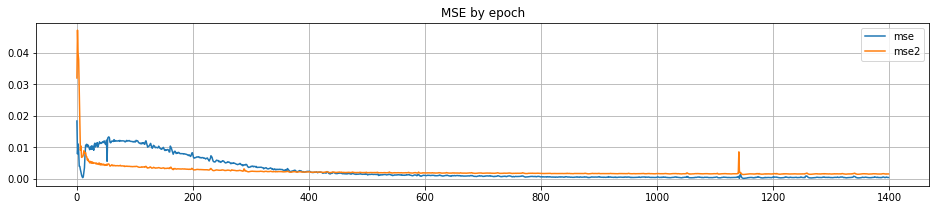

In [40]:
plt.figure(figsize=(16, 3))
plt.plot(mse_coll, label='mse')
plt.plot(mse_coll2, label='mse2')
plt.grid(True)
plt.legend()
plt.title("MSE by epoch")

### Actual and predicted data for the training set. 
It is shows how well the model can reproduce actual data. Actually, the latest part is more important than the beginning, because the last part is used as independent variable X to create a forecast as Y=f(X).

Model.delete()
INFO:tensorflow:Restoring parameters from model_state/lstm-7/ckpt/checkpoint-1479


INFO:tensorflow:Restoring parameters from model_state/lstm-7/ckpt/checkpoint-1479


model restored from model_state/lstm-7/ckpt/checkpoint-1479
step: 0
step: 2000
step: 4000
step: 6000
step: 8000
test steps: 9750, total time: 88.512


Text(0.5,1,'Actual vs Predicts. MSE=0.001910')

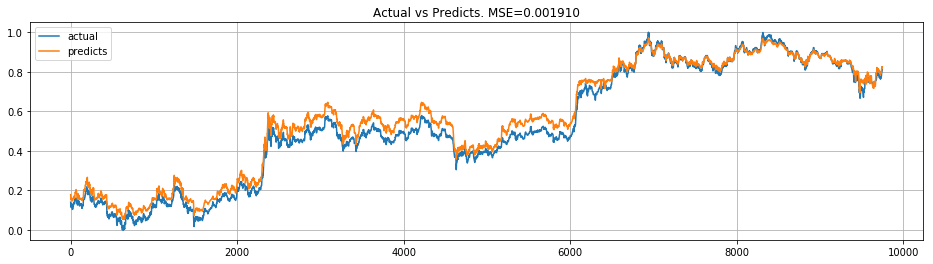

In [42]:
model = Model(SETS)
model.from_latest_point()
idx, actual, predicts = model.evaluate()
eval_mse = mean_squared_error(actual, predicts)
plt.figure(figsize=(16, 4))
plt.plot(actual, label='actual')
plt.plot(predicts, label='predicts')
plt.legend()
plt.grid()
plt.title('Actual vs Predicts. MSE={:.6f}'.format(eval_mse))

The latest part of a training set which is used in a prediction.

Text(0.5,1,'Actual vs Predicts. Last 400 values')

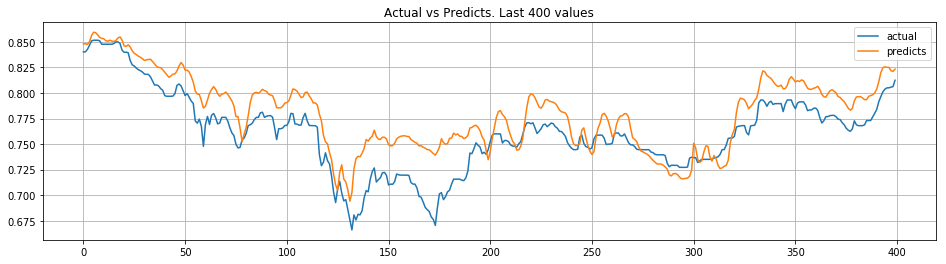

In [43]:
look_back = 400
plt.figure(figsize=(16, 4))
plt.plot(actual[-look_back:], label='actual')
plt.plot(predicts[-look_back:], label='predicts')
plt.legend()
plt.grid()
plt.title('Actual vs Predicts. Last {} values'.format(look_back))

The historgram and box plot of error between the predicted and actual values of training set. The histogram shows that the distribution looks like to skewed normal.

errors description: count    9749.000000
mean       -0.035045
std         0.026118
min        -0.081333
25%        -0.062143
50%        -0.040296
75%        -0.012452
max         0.033316
Name: error, dtype: float64


Text(0.5,1,'Error')

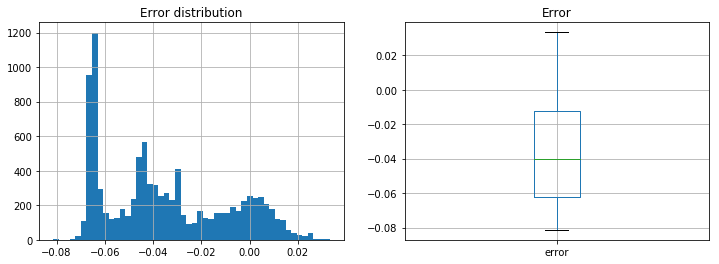

In [53]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
df = pd.DataFrame({'actual': actual, 'predicts': predicts})
df['error'] = df.actual - df.predicts
print("errors description:", df.error.describe())
df.error.hist(bins=50).set_title('Error distribution')
plt.subplot(122)
df.error.plot(kind='box', grid=True).set_title("Error")

### Calculate a confidence interval for forecasting and define decitions when the model produces a correct prediction

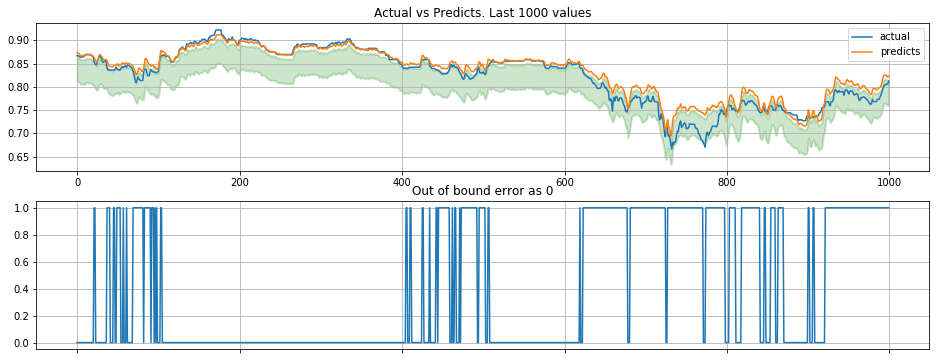

In [46]:
look_back = 1000
std_part = 1.0  # use values from 0 to 1 if you have an idea what part of STD should be used.
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(211)
act_lb = actual[-look_back:]
pred_lb = predicts[-look_back:]
err_std = df.error.std(axis=0)
err_mean = df.error.mean(axis=0)
pred_upper = pred_lb + err_mean + err_std * std_part
pred_lower = pred_lb + err_mean - err_std * std_part
err_x = np.linspace(0, len(act_lb)-1, len(act_lb))
plt.plot(actual[-look_back:], label='actual')
plt.plot(predicts[-look_back:], label='predicts')
plt.fill_between(x=err_x, y1=pred_upper, y2=pred_lower, color='green', lw=2, alpha=0.2)
plt.legend()
plt.grid()
plt.title('Actual vs Predicts. Last {} values'.format(look_back))
ax2 = plt.subplot(212, sharex=ax1)
less_upp = act_lb < pred_upper
more_lower = act_lb > pred_lower
plt.plot(np.logical_and(less_upp, more_lower))
plt.title("Out of bound error as 0")
plt.grid()
plt.setp(ax2.get_xticklabels(), visible=False);

The first graph shows the actual and predicted values, and calculated confidence interval as a filled area. The second graph depicts when the confidence interval covers the values from training set( the '1' value). 

For this particular example, for data in X range [150, 400], the model can't reproduce the training set with appropriate precision. For X in range [620, 800] the model can predict data well.